**현재 세션(1개)의 모든 클릭 로그**를 대상으로 MLP, Gaussian Naive Bayes, Decision Tree, XGBoost, Logistic Regression, Linear SVM을 사용해서 구매 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import itertools
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# <br>
# 전처리

In [3]:
온라인 = pd.read_csv('제6회 L.POINT Big Data Competition-분석용데이터-01.온라인 행동 정보.csv', encoding='utf-8')
온라인 = 온라인.sort_values(['clnt_id','sess_id','hit_seq']).reset_index(drop=True)
온라인.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(3196362, 14)

In [4]:
# {clnt_id}_{sess_id}인 unique_id 생성
온라인['unique_id'] = list(map(lambda x,y: str(x)+'_'+str(y), 온라인.clnt_id, 온라인.sess_id))
온라인.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,unique_id
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app,1_1
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app,1_1
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app,1_1
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app,1_2
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app,1_2


In [5]:
# 온라인 고객: 72,399명, 세션: 367,149개
온라인.clnt_id.nunique(), 온라인.unique_id.nunique()

(72399, 367149)

In [6]:
# 각 clnt_id별 session이 바뀌는 지점 index 저장
idx1 = 온라인.unique_id.drop_duplicates().index.tolist()
idx2 = idx1[1:] + [len(온라인)]

In [7]:
# session별 체류시간 = 다음 hit_pss_tm - 이전 hit_pss_tm
stay_tm = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.iloc[i:j].hit_pss_tm
    if len(temp) == 1:
        stay_tm.append(temp.tolist())
    else:
        temp = temp.diff().tolist()[1:]
        temp.append(temp[-1]) # 마지막은 이전 세션의 체류시간을 활용
        stay_tm.append(temp)
    #stay_tm = stay_tm + 온라인.iloc[i:j].hit_pss_tm.diff().fillna(0).tolist()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# list를 flatten
# stay_tm = sum(stay_tm, [])
온라인['time_length'] = list(itertools.chain.from_iterable(stay_tm))

In [9]:
# 밀리초 -> 초 변환
온라인['hit_pss_tm'] = np.ceil(온라인['hit_pss_tm']/1000)
온라인['time_length'] = np.ceil(온라인['time_length']/1000)

In [10]:
# 주말 및 공휴일 여부
holiday_diff = []
for i in 온라인.sess_dt.map(lambda x: str(x)[-3:]).tolist():
    if i in (['706','707','713','714','717','720','721','727','728',
               '803','804','810','811','815','817','818','824','825',
               '907','908','912','913','914','915','921','922','928','929']):
        holiday_diff.append(1)
    else:
        holiday_diff.append(0)
온라인['holiday_diff'] = holiday_diff

In [11]:
# keyword: session별 sech_kwd의 cumulative sum
온라인['sech_kwd'] = 온라인.sech_kwd.map(lambda x: 0 if str(x) == 'nan' else 1)
keyword = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.iloc[i:j].sech_kwd
    keyword.append(np.cumsum(temp.tolist()))
온라인['keyword'] = list(itertools.chain.from_iterable(keyword))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [12]:
온라인['sess_dt'] = 온라인['sess_dt'].map(lambda x: str(x)[:-2]) # day제거하고 month(7,8,9월)만 남김
온라인['dvc_ctg_nm'].fillna('unknown',inplace=True) # device null값을 unknown으로 대체

In [13]:
# dummy variable 생성 - action_type, biz_unit, sess_dt, trfc_src, dvc_ctg_nm
온라인 = pd.concat([온라인, pd.get_dummies(온라인[['biz_unit','sess_dt','trfc_src','dvc_ctg_nm']], drop_first=True)], axis=1)
온라인 = pd.concat([온라인, pd.get_dummies(온라인.action_type, drop_first=True, prefix='action_type')], axis=1)
온라인 = 온라인.drop(['action_type','biz_unit','sess_dt','hit_tm','sech_kwd','tot_pag_view_ct', 'tot_sess_hr_v','trfc_src','dvc_ctg_nm'], axis=1)

In [14]:
온라인 = 온라인[['clnt_id', 'sess_id', 'trans_id', 'hit_seq', 'hit_pss_tm', 
           'time_length', 'holiday_diff', 'keyword', 'action_type_1', 'action_type_2',
           'action_type_3','action_type_4', 'action_type_5', 'action_type_6', 'action_type_7',
           'biz_unit_A02', 'biz_unit_A03', 'sess_dt_201908', 'sess_dt_201909', 'trfc_src_PORTAL_1',
           'trfc_src_PORTAL_2', 'trfc_src_PORTAL_3', 'trfc_src_PUSH', 'trfc_src_WEBSITE', 'trfc_src_unknown', 
           'dvc_ctg_nm_mobile_app','dvc_ctg_nm_mobile_web', 'dvc_ctg_nm_unknown', 'unique_id']]
print(온라인.shape)
온라인.head()

(3196362, 29)


,clnt_id,sess_id,trans_id,hit_seq,hit_pss_tm,time_length,holiday_diff,keyword,action_type_1,action_type_2,...,trfc_src_PORTAL_1,trfc_src_PORTAL_2,trfc_src_PORTAL_3,trfc_src_PUSH,trfc_src_WEBSITE,trfc_src_unknown,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,unique_id
0,1,1,NaN,1,12.0,11.0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1_1
1,1,1,NaN,2,23.0,14.0,0,2,0,0,...,0,0,0,0,0,1,1,0,0,1_1
2,1,1,NaN,3,37.0,14.0,0,3,0,0,...,0,0,0,0,0,1,1,0,0,1_1
3,1,2,NaN,1,42.0,15.0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,1_2
4,1,2,NaN,2,57.0,14.0,1,2,0,0,...,0,0,0,0,0,1,1,0,0,1_2


In [15]:
# 저장
온라인.to_csv('온라인_전처리_final.csv', index=False)

In [2]:
# 불러오기
import pandas as pd

온라인 = pd.read_csv('온라인_전처리_final.csv')

# <br>
# 종속변수 생성
다음 세션의 구매 여부

In [3]:
# 각 hit_seq 당 action_type이 구매완료=1, 이외=0
온라인['buy'] = 온라인['action_type_6']
온라인.drop('action_type_6', inplace=True, axis=1)
print(온라인.shape)
온라인.head()

(3196362, 29)


,clnt_id,sess_id,trans_id,hit_seq,hit_pss_tm,time_length,holiday_diff,keyword,action_type_1,action_type_2,...,trfc_src_PORTAL_2,trfc_src_PORTAL_3,trfc_src_PUSH,trfc_src_WEBSITE,trfc_src_unknown,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,unique_id,buy
0,1,1,NaN,1,12.0,11.0,0,1,0,0,...,0,0,0,0,1,1,0,0,1_1,0
1,1,1,NaN,2,23.0,14.0,0,2,0,0,...,0,0,0,0,1,1,0,0,1_1,0
2,1,1,NaN,3,37.0,14.0,0,3,0,0,...,0,0,0,0,1,1,0,0,1_1,0
3,1,2,NaN,1,42.0,15.0,1,1,0,0,...,0,0,0,0,1,1,0,0,1_2,0
4,1,2,NaN,2,57.0,14.0,1,2,0,0,...,0,0,0,0,1,1,0,0,1_2,0


In [4]:
#다음 세션의 구매를 예측하기 위한 종속변수 생성
구매여부 = 온라인[['clnt_id', 'sess_id', 'buy']].groupby(['clnt_id', 'sess_id']).sum()
구매여부.buy = 구매여부.buy.apply(lambda x:0 if x == 0 else 1)
구매여부 = 구매여부.sort_index()
구매여부 = 구매여부.reset_index()
#각 clnt_id별로 shift로 1행씩 올림
구매여부.buy = 구매여부.buy.shift(-1)
g = 구매여부.groupby('clnt_id')
#1행씩 올리면 각 clnt_id별로 마지막 값은 다음 id의 값, 따라서 마지막 행 제거
구매여부.drop(g.tail(1).index, axis=0, inplace = True)

In [5]:
구매여부

,clnt_id,sess_id,buy
0,1,1,0.0
2,2,1,0.0
3,2,2,0.0
4,2,3,0.0
5,2,4,0.0
...,...,...,...
367141,72427,3,0.0
367143,72428,1,0.0
367144,72428,2,0.0
367145,72428,3,0.0


In [6]:
온라인.drop(['buy'], axis =1, inplace= True)
온라인 = pd.merge(온라인, 구매여부, left_on=['clnt_id', 'sess_id'], right_on=['clnt_id', 'sess_id'])

In [7]:
print(온라인.shape)
온라인.head()

(2750164, 29)


,clnt_id,sess_id,trans_id,hit_seq,hit_pss_tm,time_length,holiday_diff,keyword,action_type_1,action_type_2,...,trfc_src_PORTAL_2,trfc_src_PORTAL_3,trfc_src_PUSH,trfc_src_WEBSITE,trfc_src_unknown,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,unique_id,buy
0,1,1,NaN,1,12.0,11.0,0,1,0,0,...,0,0,0,0,1,1,0,0,1_1,0.0
1,1,1,NaN,2,23.0,14.0,0,2,0,0,...,0,0,0,0,1,1,0,0,1_1,0.0
2,1,1,NaN,3,37.0,14.0,0,3,0,0,...,0,0,0,0,1,1,0,0,1_1,0.0
3,2,1,NaN,1,40.0,8.0,1,1,0,0,...,0,0,0,0,0,0,0,1,2_1,0.0
4,2,1,NaN,2,48.0,1.0,1,1,1,0,...,0,0,0,0,0,0,0,1,2_1,0.0


In [48]:
features = 온라인.columns[3:-2]

# <br>
# [1-2]현재 세션(1개)의 첫번째 클릭 로그 사용
(session, sequence, variables) 3d array를 1d array로 변환하여 활용

In [8]:
from keras.preprocessing import sequence
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0

In [9]:
온라인_first_hit = 온라인[온라인.hit_seq==1].copy()

In [10]:
온라인_first_hit.head()

,clnt_id,sess_id,trans_id,hit_seq,hit_pss_tm,time_length,holiday_diff,keyword,action_type_1,action_type_2,...,trfc_src_PORTAL_2,trfc_src_PORTAL_3,trfc_src_PUSH,trfc_src_WEBSITE,trfc_src_unknown,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,unique_id,buy
0,1,1,NaN,1,12.0,11.0,0,1,0,0,...,0,0,0,0,1,1,0,0,1_1,0.0
3,2,1,NaN,1,40.0,8.0,1,1,0,0,...,0,0,0,0,0,0,0,1,2_1,0.0
46,2,2,NaN,1,14.0,10.0,0,0,0,0,...,0,0,0,0,0,0,0,1,2_2,0.0
52,2,3,NaN,1,61.0,7.0,0,0,0,0,...,0,0,0,0,0,0,0,1,2_3,0.0
57,2,4,NaN,1,5.0,870.0,0,0,1,0,...,0,0,0,0,0,0,0,1,2_4,0.0


In [11]:
온라인_x = 온라인_first_hit.iloc[:, 3:-2].values

In [12]:
온라인_x

array([[  1.,  12.,  11., ...,   1.,   0.,   0.],
       [  1.,  40.,   8., ...,   0.,   0.,   1.],
       [  1.,  14.,  10., ...,   0.,   0.,   1.],
       ...,
       [  1.,  21.,  21., ...,   1.,   0.,   0.],
       [  1.,  70., 556., ...,   1.,   0.,   0.],
       [  1., 244., 244., ...,   1.,   0.,   0.]])

In [13]:
# # (session, sequence, variables) 3d array 변환
# # 세션 별 첫번째 클릭 로그만 담기
# 온라인_x = []
# for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
#     온라인_x.append(온라인.iloc[i:j, 3:-2].values) # 온라인.iloc[i:j] -> 온라인.iloc[i]
    
# #scaler = StandardScaler() 
# #scaler = MinMaxScaler(feature_range=(0, 1))
# #온라인_x = scaler.fit_transform(np.array(온라인_x))
# 온라인_x = np.array(온라인_x)

In [14]:
# session 당 구매 여부
온라인_y = 온라인_first_hit.buy.values

In [15]:
온라인_x.shape, 온라인_y.shape

((294750, 24), (294750,))

In [16]:
def make_padding_and_oversample(X, Y, length=70):
    max_len = length
#     X_padding = sequence.pad_sequences(X, maxlen=max_len, padding='pre', truncating='post')
#     X_padding2 = X_padding.reshape(X.shape[0], max_len* X_padding.shape[2])

    smote = SMOTE(random_state=0)
    X_resampled, Y_resampled = smote.fit_resample(X, Y)
    return X_resampled, Y_resampled

In [17]:
X_resampled, Y_resampled = make_padding_and_oversample(온라인_x, 온라인_y, length=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(361313, 24)
(154849, 24)


In [30]:
# num_train = X_train.shape[0]
# num_test = X_test.shape[0]

In [31]:
# X_train_1d = X_train.reshape((num_train,-1))
# X_test_1d = X_test.reshape((num_test,-1))

# <br>
# 모델링

In [45]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import xgboost as xgb
from xgboost import plot_importance

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.layers import Dropout

import pickle
from joblib import dump, load

In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
scores = dict()

### Gaussian Naive Bayes

In [24]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

Accuracy: 0.59
F1 score: 0.66
Precision: 0.56
Recall: 0.80


In [25]:
scores['Gaussian Naive Bayes'] = [accuracy_score(y_test, y_pred),
                                                f1_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred)]

In [26]:
# dump(clf, '1-2-Gaussian.joblib')

### Decision Tree

In [27]:
clf2 = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
y_pred = clf2.predict(X_test)

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

Accuracy: 0.85
F1 score: 0.85
Precision: 0.87
Recall: 0.82


In [28]:
scores['Decision Tree'] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred),
                           precision_score(y_test, y_pred), recall_score(y_test, y_pred)]

In [42]:
clf2.feature_importances_

array([0.        , 0.18884892, 0.17840371, 0.11799572, 0.03157084,
       0.00564044, 0.12896282, 0.01533899, 0.00098044, 0.00759821,
       0.00090494, 0.00979119, 0.00410046, 0.07711255, 0.0626408 ,
       0.00227987, 0.00075364, 0.00058769, 0.04311946, 0.0016587 ,
       0.00284852, 0.04550847, 0.01662144, 0.05673219])

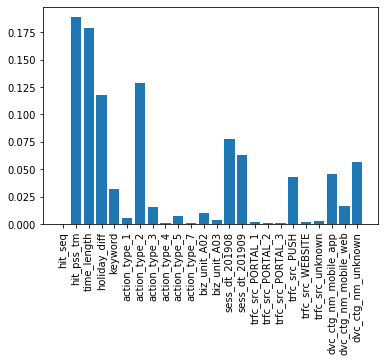

In [54]:
plt.bar(features, clf2.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [29]:
# dump(clf2, '1-2-DecisionTree.joblib')

### XGBOOST

In [30]:
clf3 = xgb.XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=3, verbosity=2, random_state=0).fit(X_train, y_train)
y_pred = clf3.predict(X_test)

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

[15:51:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:51:27] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:51:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:51:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:51:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:51:28] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:

In [31]:
scores['XGboost'] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)]

[Text(0, 0, 'hit_seq'),
 Text(0, 0, 'hit_pss_tm'),
 Text(0, 0, 'time_length'),
 Text(0, 0, 'holiday_diff'),
 Text(0, 0, 'keyword'),
 Text(0, 0, 'action_type_1'),
 Text(0, 0, 'action_type_2'),
 Text(0, 0, 'action_type_3'),
 Text(0, 0, 'action_type_4'),
 Text(0, 0, 'action_type_5'),
 Text(0, 0, 'action_type_7'),
 Text(0, 0, 'biz_unit_A02'),
 Text(0, 0, 'biz_unit_A03'),
 Text(0, 0, 'sess_dt_201908'),
 Text(0, 0, 'sess_dt_201909'),
 Text(0, 0, 'trfc_src_PORTAL_1'),
 Text(0, 0, 'trfc_src_PORTAL_2'),
 Text(0, 0, 'trfc_src_PORTAL_3'),
 Text(0, 0, 'trfc_src_PUSH'),
 Text(0, 0, 'trfc_src_WEBSITE'),
 Text(0, 0, 'trfc_src_unknown'),
 Text(0, 0, 'dvc_ctg_nm_mobile_app'),
 Text(0, 0, 'dvc_ctg_nm_mobile_web')]

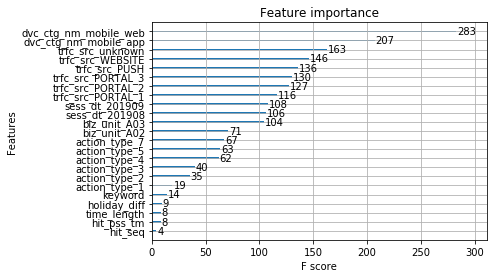

In [49]:
plot_importance(clf3).set_yticklabels(features)

In [105]:
# dump(clf3, '1-2-xgb.joblib')

### Logistic Regression

In [22]:
clf4 = LogisticRegression(max_iter=500, random_state=0).fit(X_train, y_train)
y_pred = clf4.predict(X_test)

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.60
F1 score: 0.63
Precision: 0.58
Recall: 0.69


In [23]:
scores['Logistic Regression'] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)]

In [68]:
# dump(clf4, '1-2-LogisticRegression.joblib')

### Linear SVM

In [32]:
clf5 = LinearSVC(random_state=0).fit(X_train, y_train)
y_pred = clf5.predict(X_test)

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.59
F1 score: 0.67
Precision: 0.56
Recall: 0.85


In [33]:
scores['Linear SVM'] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)]

In [110]:
# dump(clf4, '1-2-LinearSVM.joblib')

### MLP(DNN)

In [34]:
def models(train):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(train.shape[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc', f1_m, precision_m, recall_m])
    return model

In [35]:
model = models(X_train)
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                800       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=2, shuffle=True)


Train on 361313 samples, validate on 154849 samples
Epoch 1/25
 - 2s - loss: 1.0366 - acc: 0.5557 - f1_m: 0.5217 - precision_m: 0.5611 - recall_m: 0.5612 - val_loss: 0.9805 - val_acc: 0.5804 - val_f1_m: 0.6632 - val_precision_m: 0.5540 - val_recall_m: 0.8266
Epoch 2/25
 - 1s - loss: 0.8131 - acc: 0.5731 - f1_m: 0.5482 - precision_m: 0.5804 - recall_m: 0.5798 - val_loss: 0.7405 - val_acc: 0.5694 - val_f1_m: 0.4748 - val_precision_m: 0.6090 - val_recall_m: 0.3894
Epoch 3/25
 - 1s - loss: 0.7982 - acc: 0.5792 - f1_m: 0.5621 - precision_m: 0.5854 - recall_m: 0.5960 - val_loss: 0.8133 - val_acc: 0.5984 - val_f1_m: 0.6605 - val_precision_m: 0.5722 - val_recall_m: 0.7815
Epoch 4/25
 - 1s - loss: 0.7783 - acc: 0.5824 - f1_m: 0.5716 - precision_m: 0.5863 - recall_m: 0.6051 - val_loss: 0.7455 - val_acc: 0.6009 - val_f1_m: 0.6307 - val_precision_m: 0.5872 - val_recall_m: 0.6818
Epoch 5/25
 - 1s - loss: 0.7663 - acc: 0.5852 - f1_m: 0.5793 - precision_m: 0.5868 - recall_m: 0.6139 - val_loss: 0.740

In [37]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

154849/154849 [==============================] - 7s 42us/step


In [38]:
scores['DNN'] = [accuracy, f1_score, precision, recall]

In [39]:
print(loss)
print(accuracy)
print(f1_score)
print(precision)
print(recall)

0.6191196389293425
0.6509308815002441
0.676232635974884
0.625633955001831
0.750912070274353


In [124]:
# model.save('1-2-DNN.h5')

In [40]:
pd.DataFrame.from_dict(scores, orient='index', columns=['Accuracy', 'F1-Score', 'Precision', 'Recall'])

,Accuracy,F1-Score,Precision,Recall
Logistic Regression,0.595877,0.631052,0.580848,0.690756
Gaussian Naive Bayes,0.590943,0.660692,0.564714,0.795976
Decision Tree,0.849034,0.845026,0.868678,0.822629
XGboost,0.836544,0.805391,0.996006,0.676016
Linear SVM,0.585893,0.671661,0.556662,0.846546
DNN,0.650931,0.676233,0.625634,0.750912
